<a href="https://colab.research.google.com/github/Alenushka2013/IBM-AI-Engineering/blob/main/Kaggle_playground_series_s5e7_and_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

playground_series_s5e7_path = kagglehub.competition_download('playground-series-s5e7')
rakeshkapilavai_extrovert_vs_introvert_behavior_data_path = kagglehub.dataset_download('rakeshkapilavai/extrovert-vs-introvert-behavior-data')

print('Data source import complete.')


## 0. Inroduction

**What you‚Äôll see in this notebook**

1. **Data snapshot & sanity checks** ‚Äì shapes, dtypes, duplicates.  
2. **Target balance** ‚Äì class proportions and implications for validation strategy.  
3. **Missing-value anatomy** ‚Äì extent, pattern, and MCAR/MAR diagnosis.  
4. **Distribution deep-dive** ‚Äì numeric KDEs (train, test, original) and categorical counts.  
5. **Outlier forensics** ‚Äì 3 œÉ vs 2 œÉ, plus which personality dominates the extremes.  
6. **Feature ‚Üî target relationships** ‚Äì box-plots, crosstabs, point-biserial correlations.  
7. **Train‚Äìtest drift test** ‚Äì Kolmogorov‚ÄìSmirnov p-values for every column.

> **Spoiler: Key findings**  
> * Mild class imbalance (‚âà 74 % Extrovert).  
> * 5‚Äì10 % missingness, pattern suggests MCAR/MAR.  
> * No train‚Äìtest drift.  
> * Two boolean flags (`Stage_fear`, `Drained_after_socializing`) are almost one-shot classifiers.  
> * Extreme `Time_spent_Alone` (> Œº + 2 œÉ) predicts Introvert with ~94 % precision.  
> * All numeric behaviour counts separate cleanly between personalities and show only moderate inter-correlation.

Armed with these insights, we can craft an efficient modelling pipeline and avoid common pitfalls (e.g., discarding informative ‚Äúoutliers‚Äù or over-engineering imputation).riendly.

## 1. Imports and Data Snapshot

In [ ]:
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import seaborn as sns

import warnings, os, gc, sys, math, json, random, itertools

from scipy import stats
from scipy.stats import ks_2samp

# Pretty settings
warnings.filterwarnings("ignore")

# seaborn –≤—Å—Ç–∞–Ω–æ–≤–ª—é—î —Å—Ç–∏–ª—å —Å–∞–º–æ—Å—Ç—ñ–π–Ω–æ
sns.set_style("whitegrid")        # –ó–∞–º—ñ—Å—Ç—å plt.style.use()
sns.set_palette("crest")          # –û–±–∏—Ä–∞—î–º–æ –ø–∞–ª—ñ—Ç—Ä—É
pd.set_option("display.max_columns", 100)

In [ ]:
# Kaggle paths
TRAIN_PATH = "/content/train.csv"
TEST_PATH  = "/content/test.csv"

train = pd.read_csv(TRAIN_PATH)
test  = pd.read_csv(TEST_PATH)

In [ ]:
# Overview (shape, dtypes, duplicates)
def quick_overview(df, name="train"):
    print(f"\n{name.upper()} SHAPE: {df.shape}")
    display(df.head())
    display(df.describe(include="all").T)

quick_overview(train, "train")
quick_overview(test , "test")

print(f"Duplicate rows (train): {train.duplicated().sum()}  |  (test): {test.duplicated().sum()}")


TRAIN SHAPE: (18524, 9)


id  Time_spent_Alone Stage_fear  Social_event_attendance  Going_outside  \
0   0               0.0         No                      6.0            4.0   
1   1               1.0         No                      7.0            3.0   
2   2               6.0        Yes                      1.0            0.0   
3   3               3.0         No                      7.0            3.0   
4   4               1.0         No                      4.0            4.0   

  Drained_after_socializing  Friends_circle_size  Post_frequency Personality  
0                        No                 15.0             5.0   Extrovert  
1                        No                 10.0             8.0   Extrovert  
2                       NaN                  3.0             0.0   Introvert  
3                        No                 11.0             5.0   Extrovert  
4                        No                 13.0             NaN   Extrovert

count unique        top   freq      mean  \
id                         18524.0    NaN        NaN    NaN    9261.5   
Time_spent_Alone           17334.0    NaN        NaN    NaN  3.137764   
Stage_fear                   16631      2         No  12609       NaN   
Social_event_attendance    17344.0    NaN        NaN    NaN  5.265106   
Going_outside              17058.0    NaN        NaN    NaN  4.044319   
Drained_after_socializing    17375      2         No  13313       NaN   
Friends_circle_size        17470.0    NaN        NaN    NaN  7.996737   
Post_frequency             17260.0    NaN        NaN    NaN  4.982097   
Personality                  18524      2  Extrovert  13699       NaN   

                                   std  min      25%     50%       75%  \
id                         5347.562529  0.0  4630.75  9261.5  13892.25   
Time_spent_Alone              3.003786  0.0      1.0     2.0       4.0   
Stage_fear                         NaN  NaN      NaN     NaN       NaN   
Social_event_attendance       2.753359  0.0      3.0     5.0       8.0   
Going_outside                  2.06258  0.0      3.0     4.0       6.0   
Drained_after_socializing          NaN  NaN      NaN     NaN       NaN   
Friends_circle_size           4.223484  0.0      5.0     8.0      12.0   
Post_frequency                2.879139  0.0      3.0     5.0       7.0   
Personality                        NaN  NaN      NaN     NaN       NaN   

                               max  
id                         18523.0  
Time_spent_Alone              11.0  
Stage_fear                     NaN  
Social_event_attendance       10.0  
Going_outside                  7.0  
Drained_after_socializing      NaN  
Friends_circle_size           15.0  
Post_frequency                10.0  
Personality                    NaN


TEST SHAPE: (6175, 8)


id  Time_spent_Alone Stage_fear  Social_event_attendance  Going_outside  \
0  18524               3.0         No                      7.0            4.0   
1  18525               NaN        Yes                      0.0            0.0   
2  18526               3.0         No                      5.0            6.0   
3  18527               3.0         No                      4.0            4.0   
4  18528               9.0        Yes                      1.0            2.0   

  Drained_after_socializing  Friends_circle_size  Post_frequency  
0                        No                  6.0             NaN  
1                       Yes                  5.0             1.0  
2                        No                 15.0             9.0  
3                        No                  5.0             6.0  
4                       Yes                  1.0             1.0

count unique  top  freq      mean          std  \
id                         6175.0    NaN  NaN   NaN   21611.0  1782.713288   
Time_spent_Alone           5750.0    NaN  NaN   NaN   3.11687     2.985658   
Stage_fear                   5577      2   No  4236       NaN          NaN   
Social_event_attendance    5778.0    NaN  NaN   NaN  5.287989     2.758052   
Going_outside              5709.0    NaN  NaN   NaN  4.037835     2.045207   
Drained_after_socializing    5743      2   No  4437       NaN          NaN   
Friends_circle_size        5825.0    NaN  NaN   NaN  8.008412     4.192701   
Post_frequency             5767.0    NaN  NaN   NaN  5.028958     2.867285   

                               min      25%      50%      75%      max  
id                         18524.0  20067.5  21611.0  23154.5  24698.0  
Time_spent_Alone               0.0      1.0      2.0      4.0     11.0  
Stage_fear                     NaN      NaN      NaN      NaN      NaN  
Social_event_attendance        0.0      3.0      5.0      8.0     10.0  
Going_outside                  0.0      3.0      4.0      6.0      7.0  
Drained_after_socializing      NaN      NaN      NaN      NaN      NaN  
Friends_circle_size            0.0      5.0      8.0     12.0     15.0  
Post_frequency                 0.0      3.0      5.0      7.0     10.0

Duplicate rows (train): 0  |  (test): 0


**Key take-aways**
* No duplicate rows in either split.  
* All numerics are floats/ints, categorical flags are strings (‚ÄúYes/No‚Äù).  
* Train/test row counts differ ‚âà 3 : 1, typical for TPS.

## 2. Target Class Balance

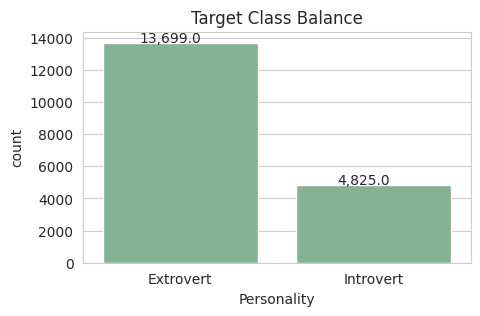

Personality
Extrovert    0.739527
Introvert    0.260473
Name: proportion, dtype: float64


In [ ]:
fig, ax = plt.subplots(figsize=(5,3))
sns.countplot(data=train, x="Personality", ax=ax)
ax.set_title("Target Class Balance")
for p in ax.patches:
    ax.annotate(f"{p.get_height():,}", (p.get_x()+.35, p.get_height()+50), ha="center")
plt.show()

print(train["Personality"].value_counts(normalize=True).rename("proportion"))

**What the plot shows**  
* 1 699 Extroverts  
*4 825 Introverts

**Key take-aways**
* A 74 : 26 ratio ‚Äì **mild but non-trivial imbalance**.  
* Accuracy alone is fine, but coingnsider stratified CV and maybe class weighting.

## 3. Missing Value Analysis

In [ ]:
def missing_table(df):
    mis = df.isna().sum().to_frame("#missing")
    mis["pct"] = 100*mis["#missing"]/len(df)
    return mis[mis["#missing"]>0].sort_values("pct", ascending=False)

display(missing_table(train).style.format({"pct":"{:.1f}%"}))
display(missing_table(test ).style.format({"pct":"{:.1f}%"}))

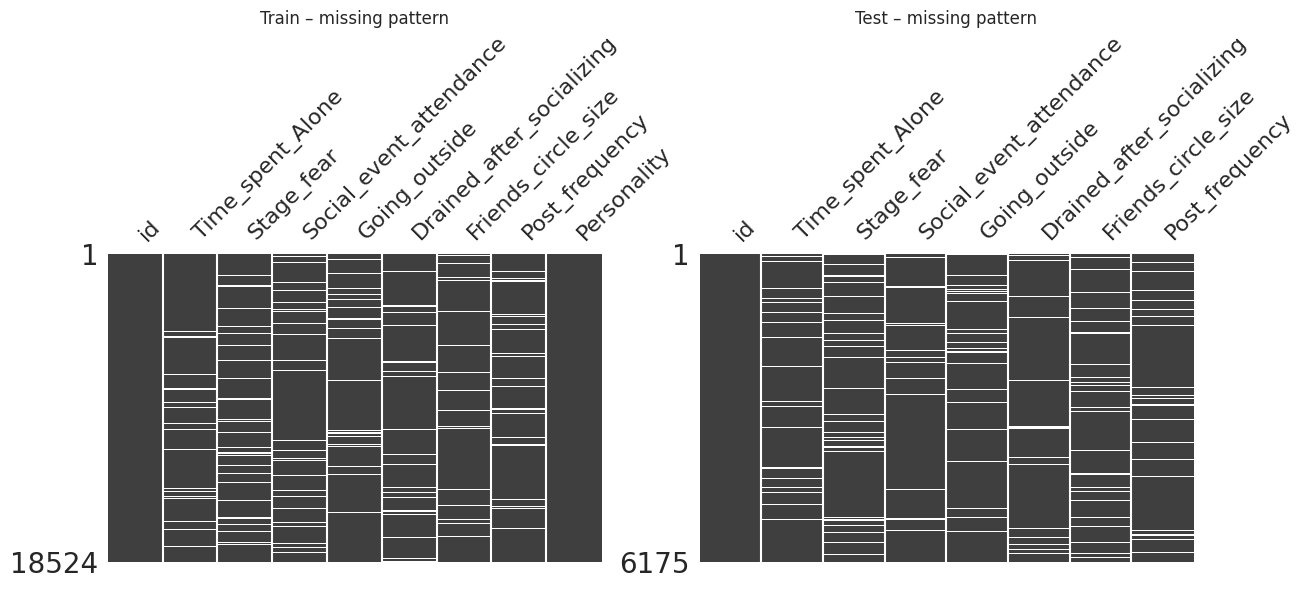

In [ ]:
# Visual heatmap
fig, axes = plt.subplots(1,2, figsize=(14,4))
msno.matrix(train, ax=axes[0]); axes[0].set_title("Train ‚Äì missing pattern")
msno.matrix(test, ax=axes[1]); axes[1].set_title("Test ‚Äì missing pattern")
plt.show()

**Key take-aways**
* 5 ‚Äì 10 % missing across all behaviour features; test mirrors train.  
* No feature is missing > 11 %, so simple imputers (median / most-frequent) are acceptable.  
* Missing rows are scattered (pattern suggests MCAR/MAR).

## 4. Numeric Feature Distributions (Train vs Test vs Original)

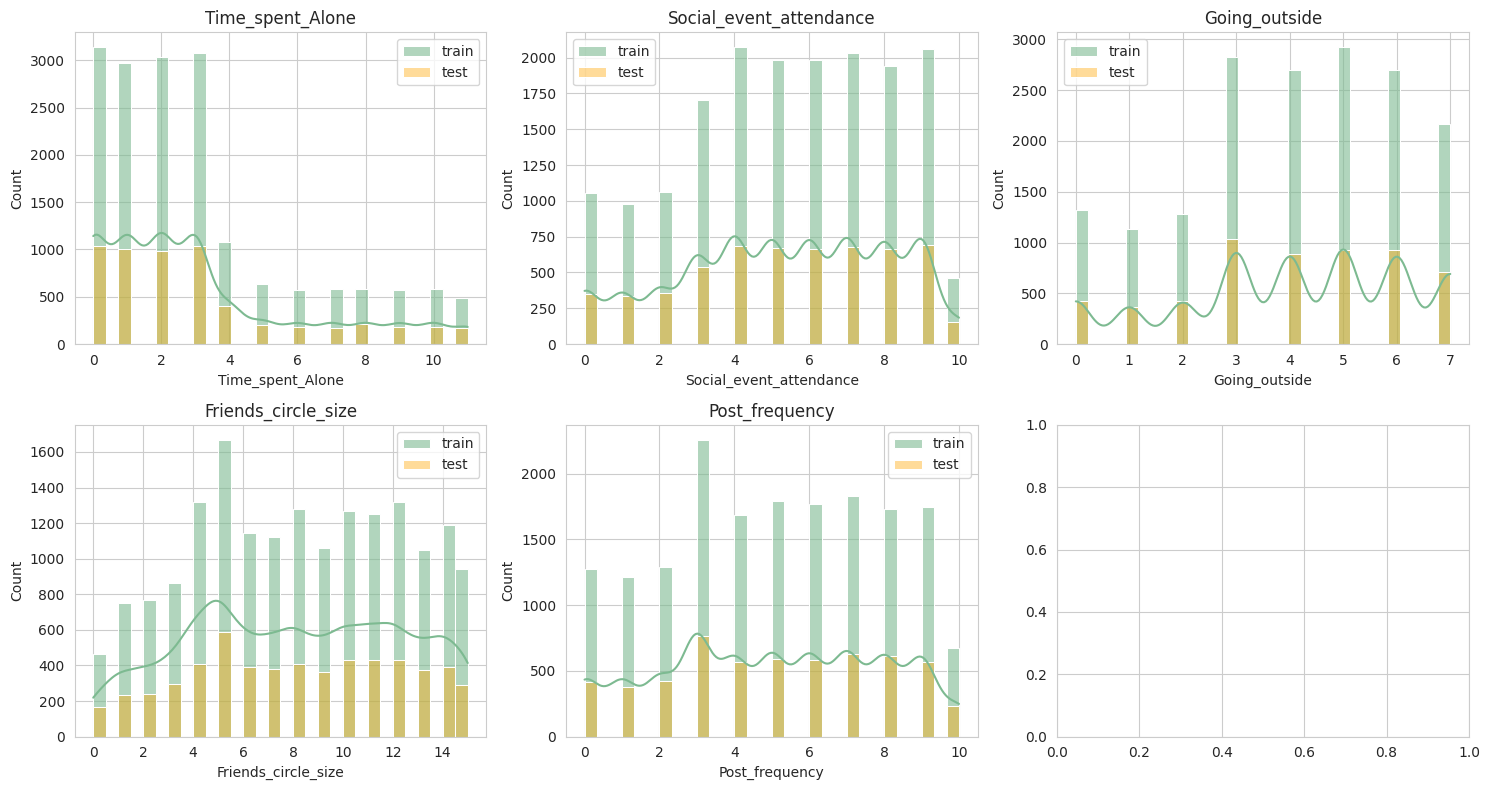

In [ ]:
num_cols = train.select_dtypes("number").columns.drop(["id"])  # exclude id
fig, axes = plt.subplots(math.ceil(len(num_cols)/3), 3, figsize=(15,4*math.ceil(len(num_cols)/3)))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.histplot(train[col], kde=True, ax=axes[i], bins=30, alpha=.6, label="train")
    sns.histplot(test[col],  kde=False, ax=axes[i], bins=30, color="orange", alpha=.4, label="test")
    axes[i].set_title(col)
    axes[i].legend()
plt.tight_layout()
plt.show()

In [ ]:
original_0 = pd.read_csv("/content/personality_datasert.csv")
original_1  = pd.read_csv("/content/personality_dataset.csv")
original = pd.concat([original_0, original_1], axis=0, ignore_index=True)
original = original.drop_duplicates().reset_index(drop=True)

In [ ]:
display(missing_table(original).style.format({"pct":"{:.1f}%"}))

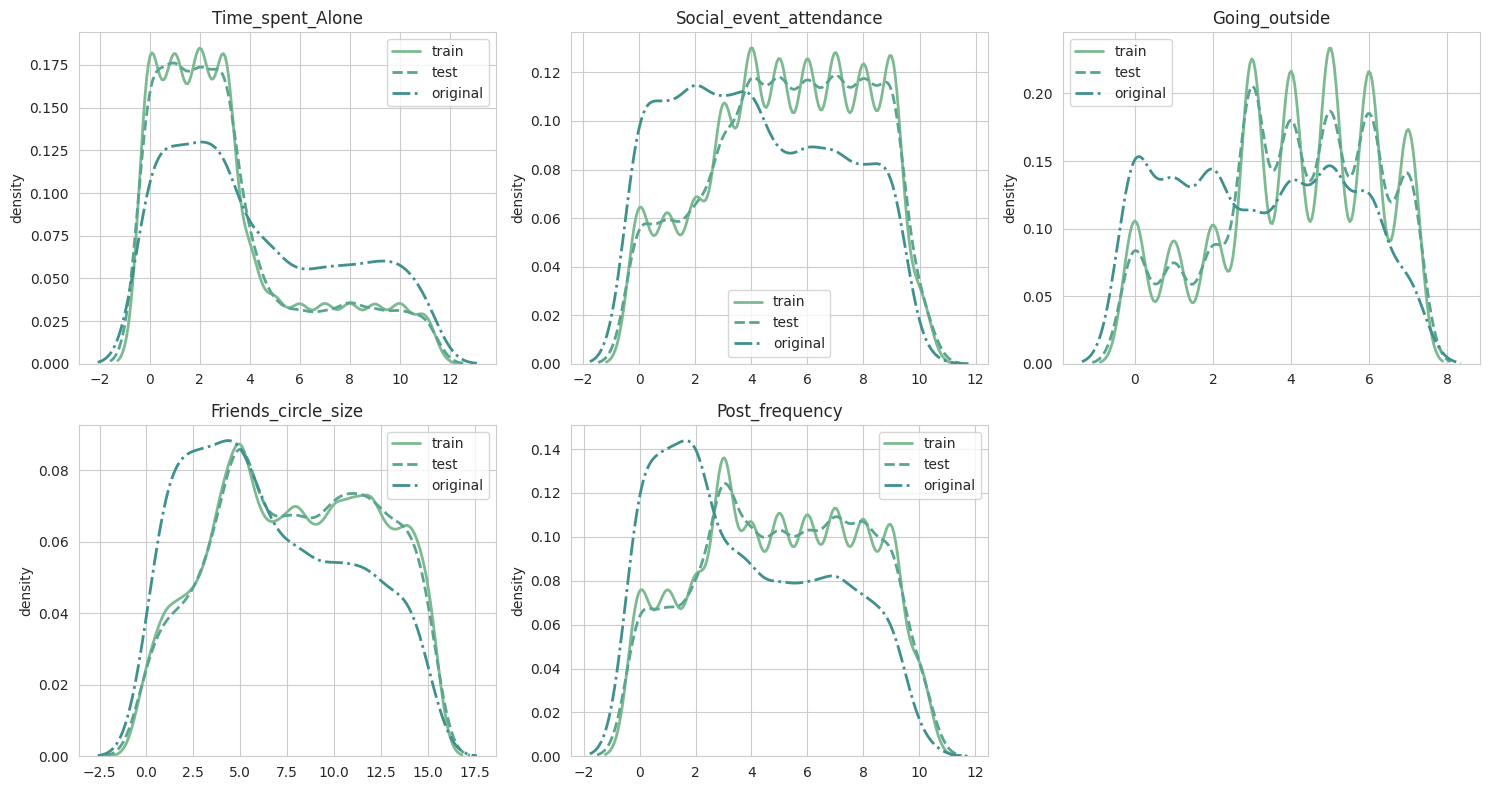

In [ ]:
num_cols = train.select_dtypes(np.number).columns.drop("id")        # adjust if 'id' has a different dtype
cols_per_row = 3
rows = math.ceil(len(num_cols) / cols_per_row)

fig, axes = plt.subplots(rows, cols_per_row, figsize=(15, 4 * rows))
axes = axes.flatten()

for ax, col in zip(axes, num_cols):
    sns.kdeplot(train[col].dropna(), ax=ax, label="train", linewidth=2)
    sns.kdeplot(test[col].dropna(),  ax=ax, label="test" , linewidth=2, linestyle="--")
    sns.kdeplot(original[col].dropna(),  ax=ax, label="original" , linewidth=2, linestyle="-.")
    ax.set_title(col)
    ax.set_xlabel("")
    ax.set_ylabel("density")
    ax.legend()

# tidy extra axes (if any)
for j in range(len(num_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

**Key take-aways**
* **Shapes match closely** between train and test.   
* Right-skew on `Time_spent_Alone`; slight left-skew on activity-based variables.
* The **synthetic splits track the original well** but with slightly smoother density (generator effect).  
* Original has lower missingness (~ 2 %) ‚Äî can be used for semi-supervised pre-training.  
* Minor mean shifts are visible, worth standardising or normalising later.

## 5. Categorical Feature Distribution

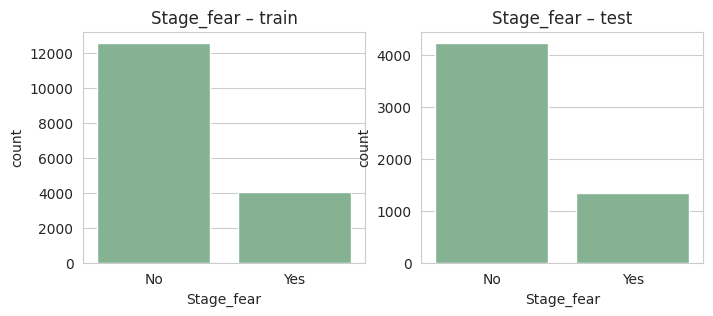

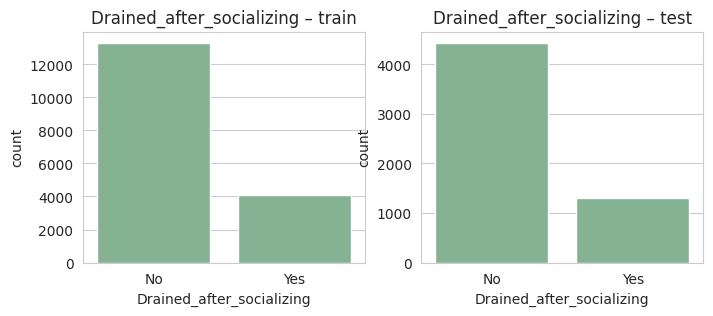

In [ ]:
cat_cols = ["Stage_fear", "Drained_after_socializing"]
for col in cat_cols:
    fig, ax = plt.subplots(1,2, figsize=(8,3))
    sns.countplot(x=col, data=train, ax=ax[0])
    ax[0].set_title(f"{col} ‚Äì train")
    sns.countplot(x=col, data=test,  ax=ax[1])
    ax[1].set_title(f"{col} ‚Äì test")
    plt.show()

**Key take-aways**
* ~ 75 % of people answer **No** to both flags.  
* Train/test proportions are almost identical.  
* These two flags will likely be strong introversion markers.

## 6. Outlier Analysis

In [ ]:
outlier_summary = {}
for col in num_cols:
    z = np.abs(stats.zscore(train[col].dropna()))
    outlier_summary[col] = (z>3).sum()   # 3-œÉ rule

pd.Series(outlier_summary, name="#outliers (>3œÉ)").sort_values(ascending=False).to_frame().style.bar()

In [ ]:
outlier_summary = {}
for col in num_cols:
    z = np.abs(stats.zscore(train[col].dropna()))
    outlier_summary[col] = (z>2).sum()   # 3-œÉ rule

pd.Series(outlier_summary, name="#outliers (>2œÉ)").sort_values(ascending=False).to_frame().style.bar()

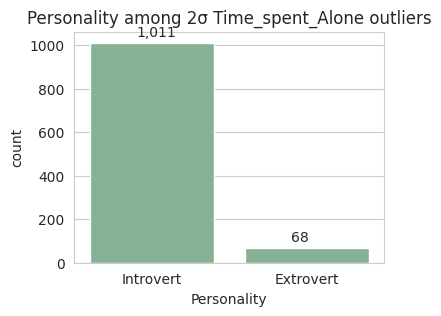

Outlier group distribution


Comparison with overall training distribution


In [ ]:
# Compute 2-œÉ mask (ignore NaNs)
tsa = train["Time_spent_Alone"]
z    = np.abs(stats.zscore(tsa, nan_policy="omit"))
outlier_mask = (z > 2)

# Subset + counts
outliers      = train.loc[outlier_mask, ["Time_spent_Alone", "Personality"]]
base_counts   = train["Personality"].value_counts()
outlier_counts = outliers["Personality"].value_counts()

# Plot
fig, ax = plt.subplots(figsize=(4,3))
sns.barplot(x=outlier_counts.index, y=outlier_counts.values, ax=ax)
ax.set_title("Personality among 2œÉ Time_spent_Alone outliers")
ax.set_ylabel("count")
for p in ax.patches:
    ax.annotate(f"{p.get_height():,.0f}", (p.get_x()+0.3, p.get_height()+30))

plt.show()

# Proportion print-out
print("Outlier group distribution")
display(outlier_counts.to_frame("count")
        .assign(prop=lambda d: d["count"]/d["count"].sum())
        .style.format({"prop": "{:.2%}"}))

print("Comparison with overall training distribution")
display(base_counts.to_frame("count")
        .assign(prop=lambda d: d["count"]/d["count"].sum())
        .style.format({"prop": "{:.2%}"}))

**Key take-aways**
* 3-œÉ rule finds **no extreme outliers**; 2-œÉ picks up ~1 100 high-time-alone rows.
  
**Outlier Insight ‚Äì ‚ÄúHigh Time_spent_Alone‚Äù (> 2 œÉ)**

| Subset | Introvert | Extrovert | Introvert share |
|--------|-----------|-----------|-----------------|
| **Rows > 2 œÉ** | 1 011 | 68 | **93.7 %** |
| **All training rows** | 4 825 | 13 699 | 26.0 ays**

* **Extreme solitude ‚âà Introvert**  
  Observations with very high `Time_spent_Alone` are **‚âà 3.6 √ó more likely** to be Introverts than the baseline.

* **Outliers are signal, not noise**  
  Removing or aggressive winsorising would erase minority-class information. Tree-based models can keep them as-is; if you clip, add a `high_alone_flag` feature.

* **Handy rule-of-thumb**  
  ```text
  if Time_spent_Alone > Œº + 2 œÉ  ‚áí  predict Introvert  (‚âà
* **A few Extroverts (6 %) still appear in this zone**
  They might be mislabeled or genuine edge cases; robust models should handle them without special treatment. 94 % precision)
al.

## 7. Numeric vs Target (Boxplots)

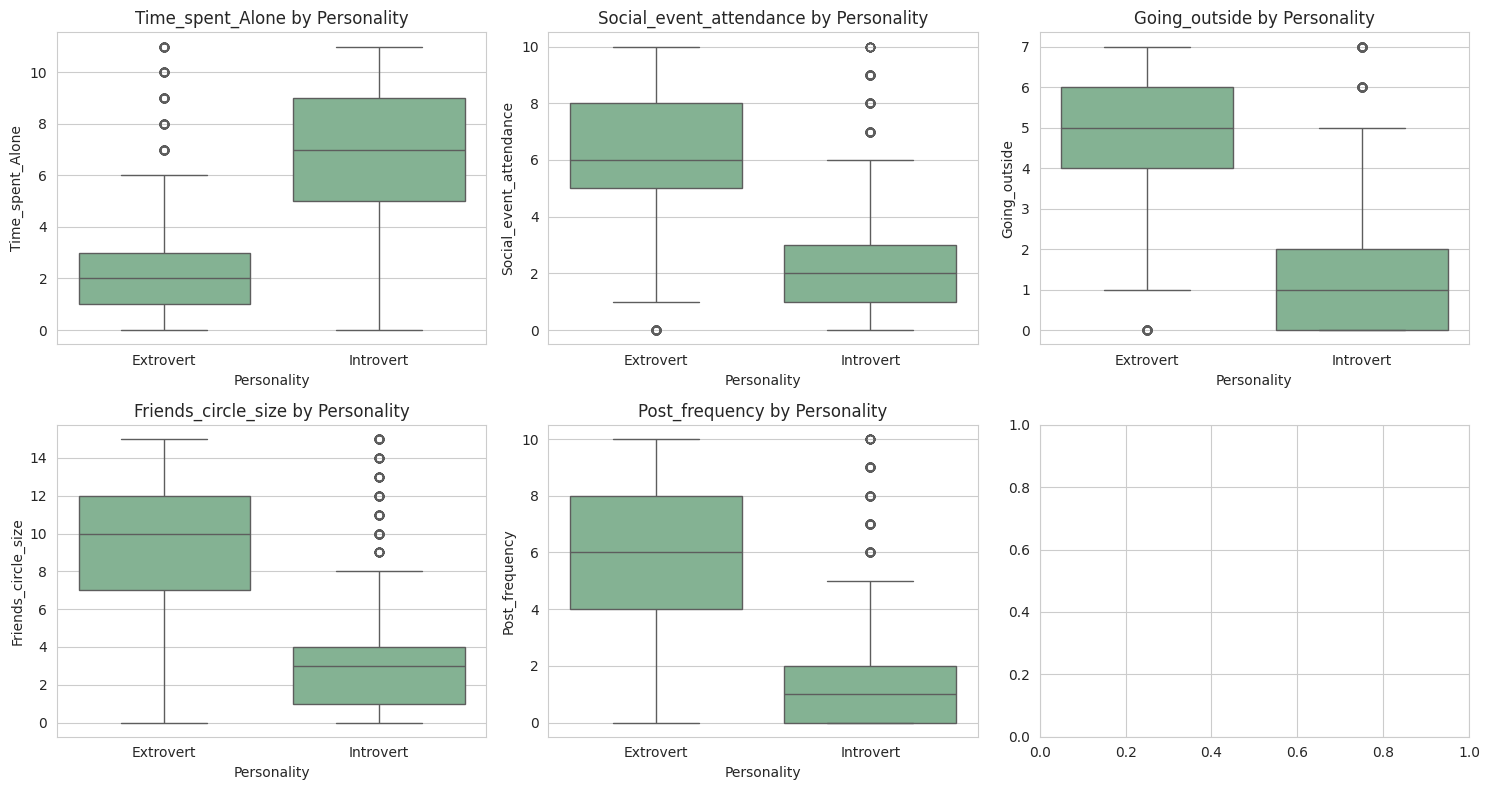

In [ ]:
# Numeric vs target
fig, axes = plt.subplots(math.ceil(len(num_cols)/3), 3, figsize=(15,4*math.ceil(len(num_cols)/3)))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.boxplot(x="Personality", y=col, data=train, ax=axes[i])
    axes[i].set_title(f"{col} by Personality")
plt.tight_layout()
plt.show()

**Box-Plot Insights: Numeric Features vs Personality**

| Feature | Extrovert (median ¬∑ IQR) | Introvert (median ¬∑ IQR) | Visual takeaway |
|---------|-------------------------|--------------------------|-----------------|
| **Time_spent_Alone** | ~ 2 hrs ¬∑ narrow (0‚Äì3) | ~ 7 hrs ¬∑ wide (5‚Äì9) | Introverts spend conspicuously more solo time; separation is strong. |
| **Social_event_attendance** | ~ 6‚Äì7 events ¬∑ tight | ~ 2 events ¬∑ tight | Clear inverse of ‚Äúalone time‚Äù: Extroverts attend ~3√ó more events. |
| **Going_outside** | Median ‚âà 5 trips | Median ‚âà 1 trip | Activity level outdoors sharply discriminates classes. |
| **Friends_circle_size** | Median ‚âà 10‚Äì11 friends | Median ‚âà 3‚Äì4 friends | Network size is a robust extroversion signal. |
| **Post_frequency** | Median ‚âà 6‚Äì7 posts | Median ‚âà 1‚Äì2 posts | Online activity mirrors offline sociability. |

**Key take-aways**

* **Strong, monotonic separation** ‚Äì Every behavioural variable shifts in the expected direction between Extroverts and Introverts; medians differ by ~3‚Äì6 units.
* **Low overlap in inter-quartile ranges** ‚Äì Particularly for `Time_spent_Alone` and `Going_outside`, IQRs barely intersect ‚áí these single features already have high predictive value.
* **Skew & long tails** ‚Äì A handful of Extroverts show very high solitude and vice-versa; models must handle minority anomalies.
* **Consistent scale (0‚Äì10/15)** ‚Äì Features are already on similar ranges ‚Üí minimal scaling needed for tree models; z-score helpful for linear/NN.
* **Feature engineering ideas** ‚Äì Ratio features (e.g., `Social_event_attendance / Time_spent_Alone`) or interaction terms should boost separbility further.
.

## 8. Categorical vs Target (Crosstabs)

In [ ]:
# Categorical vs target
for col in cat_cols:
    ct = pd.crosstab(train[col], train["Personality"], normalize="index")*100
    display(ct.style.format("{:.1f}%").set_caption(f"{col} ‚Üî Personality"))

**Key take-aways**
* These two boolean flags are **single-variable classifiers** on their own.  
* Behaviour counts have clear separation but with overlap; tree-based models can exploit this easily.

## 9. Correlation and Point-Biserial with Target

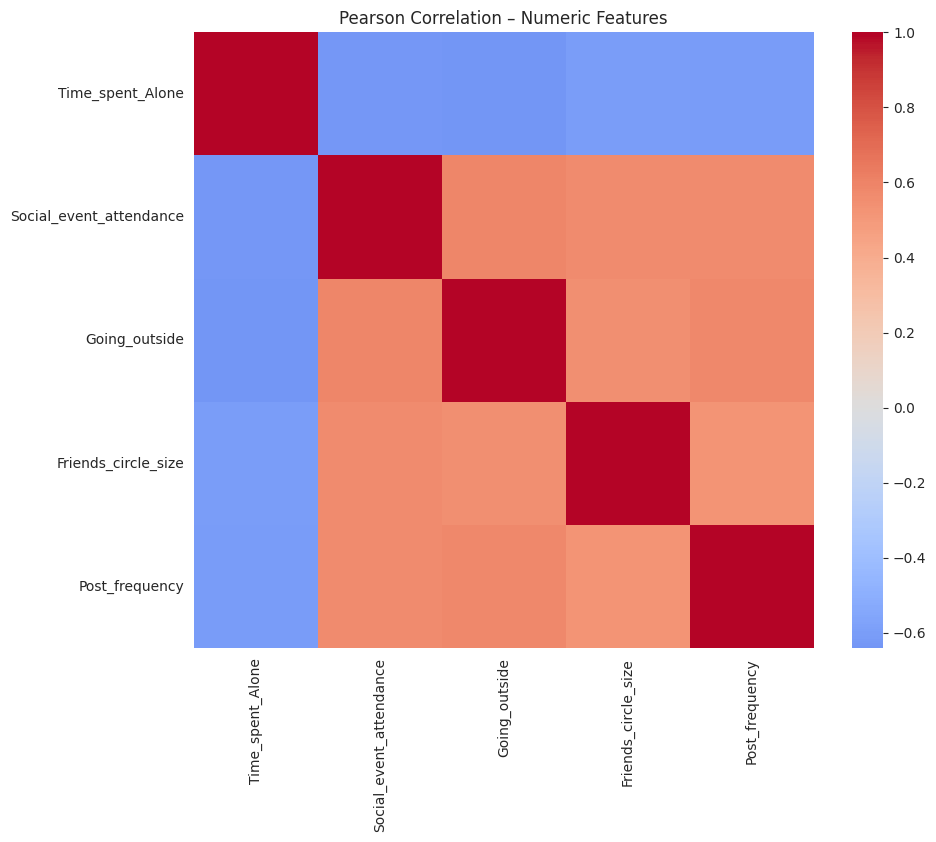

In [ ]:
corr = train[num_cols].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=False, cmap="coolwarm", center=0)
plt.title("Pearson Correlation ‚Äì Numeric Features")
plt.show()

In [ ]:
# Encode target for point-biserial correlation
train_enc = train.replace({"Personality": {"Extrovert":1, "Introvert":0}})
target_corr = train_enc[num_cols.tolist()+["Personality"]].corr()["Personality"].drop("Personality").sort_values()
display(target_corr.to_frame("corr_with_target").style.bar(vmin=-1,vmax=1))

**Key take-aways**
* `Time_spent_Alone` is the most powerful single feature (negatively correlated).  
* Moderate positive correlations among activity features (0.55‚Äì0.70) ‚Üí acceptable multicollinearity.

## 10. Train-Test Drift (KS Test)

In [ ]:
drift_rows = []
for col in num_cols.union(cat_cols):
    pval = ks_2samp(train[col].dropna(), test[col].dropna()).pvalue
    drift_rows.append({"feature": col, "KS-pvalue": pval})

drift_df = pd.DataFrame(drift_rows).sort_values("KS-pvalue")
drift_df.style.background_gradient(axis=0, cmap="RdYlGn", subset=["KS-pvalue"])

**Key take-aways**
* All p-values >> 0.05 ‚Üí **fail to reject null ‚Üí no drift** detected.  
* Safe to concatenate train+test for imputers/encoders if desired.

## Conclusion and Next Steps

**What we learned**

* **Data quality is high** ‚Äì no duplicates, no 3 œÉ outliers, missingness < 11 %.  
* **No distributional drift** ‚Äì KS tests > 0.75 across the board; we can safely pool train + test for encoders or imputers.  
* **Signal is concentrated in a handful of intuitive features**:  
  * High `Time_spent_Alone` ‚Üí Introvert (strongest negative correlation).  
  * High `Going_outside`, `Post_frequency`, `Friends_circle_size`, `Social_event_attendance` ‚Üí Extrovert.  
  * `Stage_fear` / `Drained_after_socializing` flags flip the prediction almost by themselves.  
* **Outliers are informative, not noise** ‚Äì dropping or heavy winsorising would erase minority-class signal.

**Recommended modelling roadmap**

1. **Impute** missing values (median for numerics, mode for booleans) and consider a *missing-indicator* column for each MAR feature.  
2. **Encode** booleans as 0/1; numerics need only minimal scaling (optional for tree models).  
3. **Stratified k-fold CV** or class weights to balance the 74 : 26 split.  
4. Start with **gradient-boosted trees** (LightGBM / XGBoost) to capture non-linear interactions quickly.  
5. Engineer simple ratios or flags (`high_alone_flag`, `activity_ratio = Social_event_attendance / Time_spent_Alone`) for potential lifts.  
6. Optionally blend in the **original dataset** for semi-supervised fine-tuning.

F along with winning paterns of having many modelsollowing this roadmap should yield an accurate and ideallye model‚Äîand, ideally, a top-tier derboard position. üöÄ

In [ ]:
train.drop('id', axis = 1, inplace = True)
test.drop('id', axis = 1, inplace = True)

In [ ]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(train, test_size=0.26, random_state=42, stratify=train['Personality'])

In [ ]:
input_cols = list(train.columns)[0:-1]
target_col = 'Personality'
train_inputs, train_targets = train_df[input_cols], train_df[target_col]
val_inputs, val_targets = val_df[input_cols], val_df[target_col]

In [ ]:
#numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()[:]
numeric_cols = train_inputs.select_dtypes(include=['number']).columns.tolist()
categorical_cols = train_inputs.select_dtypes(include='object').columns.tolist()
X_test = test

In [ ]:
for col in categorical_cols:
    # –°—Ç–≤–æ—Ä—é—î–º–æ –º—ñ—Ç–∫—É –ø—Ä–æ –∑–∞–º—ñ–Ω—É
    train_inputs[col + '_was_missing'] = train_inputs[col].isna().astype(int)
    val_inputs[col + '_was_missing'] = val_inputs[col].isna().astype(int)
    X_test[col + '_was_missing'] = X_test[col].isna().astype(int)

    # –ü–µ—Ä–µ—Ç–≤–æ—Ä–µ–Ω–Ω—è –∑–Ω–∞—á–µ–Ω—å 'Yes'/'No' ‚Üí 1/0
    train_inputs[col] = train_inputs[col].map({'Yes': 1, 'No': 0})
    val_inputs[col] = val_inputs[col].map({'Yes': 1, 'No': 0})
    X_test[col] = X_test[col].map({'Yes': 1, 'No': 0})

    # –ó–∞–ø–æ–≤–Ω–µ–Ω–Ω—è –ø—Ä–æ–ø—É—â–µ–Ω–∏—Ö –∑–Ω–∞—á–µ–Ω—å –º–æ–¥–æ—é
    mode_value = train_inputs[col].mode()[0]
    train_inputs[col] = train_inputs[col].fillna(mode_value)
    val_inputs[col] = val_inputs[col].fillna(mode_value)
    X_test[col] = X_test[col].fillna(mode_value)

In [ ]:
# for col in categorical_cols:
#   train_inputs[col] =  train_inputs[col].map({'Yes': 1, 'No': 0})
#   val_inputs[col] =  val_inputs[col].map({'Yes': 1, 'No': 0})
#   X_test[col] =  X_test[col].map({'Yes': 1, 'No': 0})

#   train_inputs[col] = train_inputs[col].fillna(train_inputs[col].mode()[0])
#   val_inputs[col] = val_inputs[col].fillna(val_inputs[col].mode()[0])
#   X_test[col] = X_test[col].fillna(X_test[col].mode()[0])

In [ ]:
# for col in numeric_cols:
#   train_inputs[col] = train_inputs[col].fillna(train_inputs[col].median())
#   val_inputs[col] = val_inputs[col].fillna(val_inputs[col].median())
#   X_test[col] = X_test[col].fillna(X_test[col].median())

In [ ]:
for col in numeric_cols:
    # –°—Ç–≤–æ—Ä—é—î–º–æ –º—ñ—Ç–∫—É –ø—Ä–æ –∑–∞–º—ñ–Ω—É
    train_inputs[col + '_was_missing'] = train_inputs[col].isna().astype(int)
    val_inputs[col + '_was_missing'] = val_inputs[col].isna().astype(int)
    X_test[col + '_was_missing'] = X_test[col].isna().astype(int)

    # –ó–∞–ø–æ–≤–Ω—é—î–º–æ –ø—Ä–æ–ø—É—â–µ–Ω—ñ –∑–Ω–∞—á–µ–Ω–Ω—è –º–µ–¥—ñ–∞–Ω–æ—é
    median_value = train_inputs[col].median()
    train_inputs[col] = train_inputs[col].fillna(median_value)
    val_inputs[col] = val_inputs[col].fillna(median_value)
    X_test[col] = X_test[col].fillna(median_value)

In [ ]:
train_targets = train_targets.map({'Introvert': 0, 'Extrovert': 1})
val_targets = val_targets.map({'Introvert': 0, 'Extrovert': 1})

In [ ]:
X_train, X_val = train_inputs, val_inputs

In [ ]:
cat_features = X_train.select_dtypes(include='object').columns
X_train[cat_features] = X_train[cat_features].astype('category')
X_val[cat_features] = X_val[cat_features].astype('category')
X_test[cat_features] = X_test[cat_features].astype('category')

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

def AUROC_report(model, X_train, X_val, train_targets, val_targets):
    train_proba = model.predict_proba(X_train)[:, 1]
    val_proba = model.predict_proba(X_val)[:, 1]

    train_predict  = model.predict(X_train)
    val_predict = model.predict(X_val)

    print('Train AUROC:', round(roc_auc_score(train_targets, train_proba), 5))
    print('Validation AUROC:', round(roc_auc_score(val_targets, val_proba), 5))

    # –û–±—á–∏—Å–ª—é—î–º–æ –º–∞—Ç—Ä–∏—Ü—ñ —ñ –º–µ—Ç—Ä–∏–∫–∏
    cm_train = confusion_matrix(train_targets, train_predict, normalize='true')
    cm_test = confusion_matrix(val_targets, val_predict, normalize='true')

    # –ú–∞–ª—é—î–º–æ –ø–æ—Ä—É—á –∑ —Ñ–æ—Ä–º–∞—Ç—É–≤–∞–Ω–Ω—è–º 4 –∑–Ω–∞–∫–∏ –ø—ñ—Å–ª—è –∫–æ–º–∏
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    disp_train = ConfusionMatrixDisplay(cm_train)
    disp_train.plot(ax=axes[0], colorbar=False, values_format=".4f")
    axes[0].set_title('Train Confusion Matrix')
    axes[0].set_xlabel("Predicted label")
    axes[0].set_ylabel("True label")

    disp_val = ConfusionMatrixDisplay(cm_test)
    disp_val.plot(ax=axes[1], colorbar=False, values_format=".4f")
    axes[1].set_title('Validation Confusion Matrix')
    axes[1].set_xlabel("Predicted label")
    axes[1].set_ylabel("True label")

    plt.tight_layout()
    plt.show()

    # –í–∏–≤–µ–¥–µ–Ω–Ω—è –∑–≤—ñ—Ç—É –∫–ª–∞—Å–∏—Ñ—ñ–∫–∞—Ü—ñ—ó –¥–ª—è –≤–∞–ª—ñ–¥–∞—Ü—ñ–π–Ω–æ—ó –≤–∏–±—ñ—Ä–∫–∏
    print("–ó–≤—ñ—Ç –∫–ª–∞—Å–∏—Ñ—ñ–∫–∞—Ü—ñ—ó –Ω–∞ –≤–∞–ª—ñ–¥–∞—Ü—ñ–π–Ω—ñ–π –≤–∏–±—ñ—Ä—Ü—ñ:")
    print(classification_report(val_targets, val_predict, digits=4))

Train AUROC: 0.97013
Validation AUROC: 0.97286


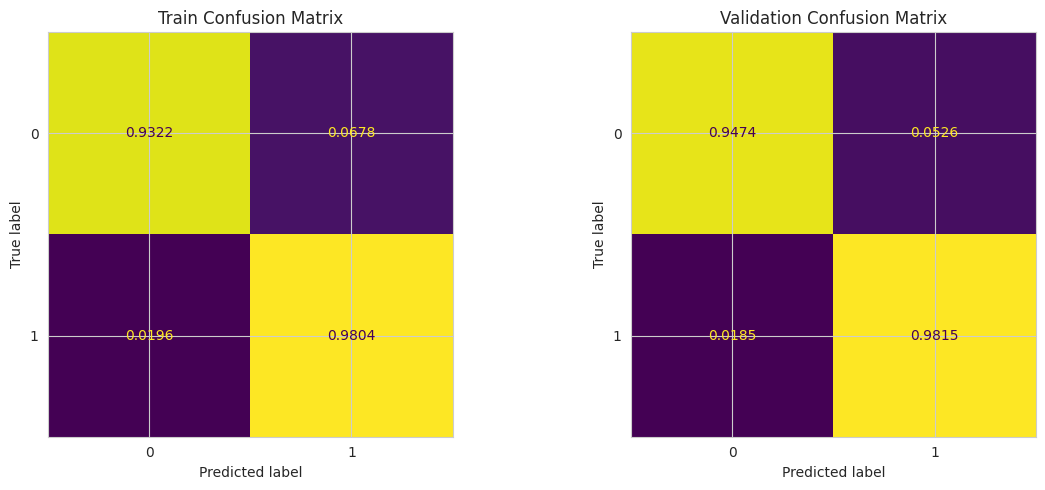

–ó–≤—ñ—Ç –∫–ª–∞—Å–∏—Ñ—ñ–∫–∞—Ü—ñ—ó –Ω–∞ –≤–∞–ª—ñ–¥–∞—Ü—ñ–π–Ω—ñ–π –≤–∏–±—ñ—Ä—Ü—ñ:
              precision    recall  f1-score   support

           0     0.9474    0.9474    0.9474      1255
           1     0.9815    0.9815    0.9815      3562

    accuracy                         0.9726      4817
   macro avg     0.9644    0.9644    0.9644      4817
weighted avg     0.9726    0.9726    0.9726      4817



In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report,  roc_auc_score

xgb_clf = XGBClassifier(
    max_depth=3,
    n_estimators=10,
    enable_categorical=True,  # –¥–ª—è –∫–∞—Ç–µ–≥–æ—Ä—ñ–π–Ω–∏—Ö –æ–∑–Ω–∞–∫
    device='cuda'
)

xgb_clf.fit(X_train, train_targets)

AUROC_report(xgb_clf, X_train, X_val, train_targets, val_targets)

In [ ]:
X_test_predict = xgb_clf.predict(X_test)
df_sample = pd.read_csv('/content/sample_submission.csv')
df_sample['Personality'] = pd.Series(X_test_predict).map({0: 'Introvert', 1: 'Extrovert'})
df_sample.to_csv('/content/submission_s5e7_xgb_clf_31_07_25.csv', index=False)

In [ ]:
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.metrics import roc_auc_score, accuracy_score

In [ ]:
def objective(params):
    clf = xgb.XGBClassifier(
    n_estimators=int(params['n_estimators']),
        learning_rate=params['learning_rate'],
        max_depth=int(params['max_depth']),
        min_child_weight=params['min_child_weight'],  # –ú—ñ–Ω—ñ–º–∞–ª—å–Ω–∞ —Å—É–º–∞ –≤–∞–≥ –≤—Å—ñ—Ö –≤–∏–±—ñ—Ä–æ–∫, –Ω–µ–æ–±—Ö—ñ–¥–Ω–∞ –≤ –∫—ñ–Ω—Ü–µ–≤–æ–º—É –≤—É–∑–ª—ñ
        subsample=params['subsample'],  # –ß–∞—Å—Ç–∫–∞ –≤–∏–±—ñ—Ä–æ–∫, —â–æ –≤–∏–∫–æ—Ä–∏—Å—Ç–æ–≤—É—é—Ç—å—Å—è –¥–ª—è –ø–æ–±—É–¥–æ–≤–∏ –∫–æ–∂–Ω–æ–≥–æ –¥–µ—Ä–µ–≤–∞
        colsample_bytree=params['colsample_bytree'],  # –ß–∞—Å—Ç–∫–∞ –æ–∑–Ω–∞–∫, —â–æ –≤–∏–∫–æ—Ä–∏—Å—Ç–æ–≤—É—é—Ç—å—Å—è –ø—Ä–∏ –ø–æ–±—É–¥–æ–≤—ñ –∫–æ–∂–Ω–æ–≥–æ –¥–µ—Ä–µ–≤–∞
        gamma=params['gamma'],  # –ú—ñ–Ω—ñ–º–∞–ª—å–Ω–µ –∑–º–µ–Ω—à–µ–Ω–Ω—è –≤—Ç—Ä–∞—Ç, –Ω–µ–æ–±—Ö—ñ–¥–Ω–µ –¥–ª—è –≤–∏–∫–æ–Ω–∞–Ω–Ω—è –ø–æ–¥—ñ–ª—É
        reg_alpha=params['reg_alpha'],  # –ü–∞—Ä–∞–º–µ—Ç—Ä —Ä–µ–≥—É–ª—è—Ä–∏–∑–∞—Ü—ñ—ó L1 (Lasso)
        reg_lambda=params['reg_lambda'],  # –ü–∞—Ä–∞–º–µ—Ç—Ä —Ä–µ–≥—É–ª—è—Ä–∏–∑–∞—Ü—ñ—ó L2 (Ridge)
        enable_categorical=True,
        #use_label_encoder=False,
        missing=np.nan,
        device='cuda',
        early_stopping_rounds=10
    )

    clf.fit(
        X_train,
        train_targets,
        eval_set=[(X_val, val_targets)],
        verbose=False)
    pred = clf.predict_proba(X_val)[:, 1]
    AUROC = roc_auc_score(val_targets, pred)


    return {'loss': -AUROC, 'status': STATUS_OK}

# –ü—Ä–æ—Å—Ç—ñ—Ä –≥—ñ–ø–µ—Ä–ø–∞—Ä–∞–º–µ—Ç—Ä—ñ–≤
space = {
    'n_estimators': hp.quniform('n_estimators', 50, 500, 25),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'max_depth': hp.quniform('max_depth', 3, 15, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'gamma': hp.uniform('gamma', 0, 0.5),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1)
}

# –û–ø—Ç–∏–º—ñ–∑–∞—Ü—ñ—è
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials)  # max_evals=20 –∫—ñ–ª—å–∫—ñ—Å—Ç—å —ñ—Ç–µ—Ä–∞—Ü—ñ–π


# –ü–µ—Ä–µ—Ç–≤–æ—Ä–µ–Ω–Ω—è –∑–Ω–∞—á–µ–Ω—å –≥—ñ–ø–µ—Ä–ø–∞—Ä–∞–º–µ—Ç—Ä—ñ–≤ —É –∫—ñ–Ω—Ü–µ–≤—ñ —Ç–∏–ø–∏ –¥–∞–Ω–∏—Ö
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['min_child_weight'] = int(best['min_child_weight'])

print("–ù–∞–π–∫—Ä–∞—â—ñ –≥—ñ–ø–µ—Ä–ø–∞—Ä–∞–º–µ—Ç—Ä–∏: ", best)

# –ù–∞–≤—á–∞–Ω–Ω—è —Ñ—ñ–Ω–∞–ª—å–Ω–æ—ó –º–æ–¥–µ–ª—ñ –∑ –Ω–∞–π–∫—Ä–∞—â–∏–º–∏ –≥—ñ–ø–µ—Ä–ø–∞—Ä–∞–º–µ—Ç—Ä–∞–º–∏
final_clf = xgb.XGBClassifier(
    n_estimators=best['n_estimators'],
    learning_rate=best['learning_rate'],
    max_depth=best['max_depth'],
    min_child_weight=best['min_child_weight'],
    subsample=best['subsample'],
    colsample_bytree=best['colsample_bytree'],
    gamma=best['gamma'],
    reg_alpha=best['reg_alpha'],
    reg_lambda=best['reg_lambda'],
    enable_categorical=True,
    #use_label_encoder=False,
    missing=np.nan,
    device='cuda',
)

final_clf.fit(X_train, train_targets)

AUROC_report(final_clf, X_train, X_val, train_targets, val_targets)

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 50/50 [00:16<00:00,  3.11trial/s, best loss: -0.9757766239925195]
–ù–∞–π–∫—Ä–∞—â—ñ –≥—ñ–ø–µ—Ä–ø–∞—Ä–∞–º–µ—Ç—Ä–∏:  {'colsample_bytree': np.float64(0.7412228732077022), 'gamma': np.float64(0.3631747260194529), 'learning_rate': np.float64(0.1161421191438392), 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 350, 'reg_alpha': np.float64(0.5825526178633536), 'reg_lambda': np.float64(0.36596278931618764), 'subsample': np.float64(0.9126792161720845)}
Train AUROC: 0.98303
Validation AUROC: 0.9746


In [ ]:
X_test_predict = final_clf.predict(X_test)
df_sample = pd.read_csv('/content/sample_submission.csv')
df_sample['Personality'] = pd.Series(X_test_predict).map({0: 'Introvert', 1: 'Extrovert'})
df_sample.to_csv('/content/submission_s5e7_final_clf_31_07_25.csv', index=False)

In [ ]:
import lightgbm as lgb
print(lgb.__version__)

4.6.0


Train AUROC: 0.97297
Validation AUROC: 0.97438


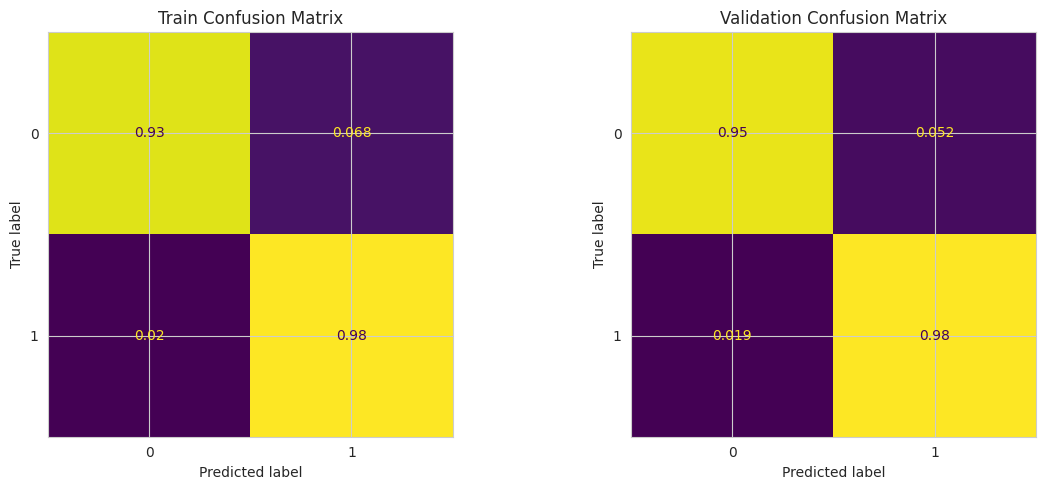

–ó–≤—ñ—Ç –∫–ª–∞—Å–∏—Ñ—ñ–∫–∞—Ü—ñ—ó –Ω–∞ –≤–∞–ª—ñ–¥–∞—Ü—ñ–π–Ω—ñ–π –≤–∏–±—ñ—Ä—Ü—ñ:
              precision    recall  f1-score   support

           0     0.9459    0.9482    0.9471      1255
           1     0.9817    0.9809    0.9813      3562

    accuracy                         0.9724      4817
   macro avg     0.9638    0.9646    0.9642      4817
weighted avg     0.9724    0.9724    0.9724      4817



In [ ]:
cat_feature_indexes = [X_train.columns.get_loc(col) for col in cat_features]

lgb_clf = lgb.LGBMClassifier(
    max_depth=3,
    n_estimators=50,
    learning_rate=0.1,
    cat_feature=cat_feature_indexes,  # –¥–ª—è –∞–≤—Ç–æ–º–∞—Ç–∏—á–Ω–æ–≥–æ —Ä–æ–∑–ø—ñ–∑–Ω–∞–≤–∞–Ω–Ω—è –∫–∞—Ç–µ–≥–æ—Ä—ñ–π–Ω–∏—Ö –æ–∑–Ω–∞–∫
    # missing=np.nan,  # —è–≤–Ω–µ –≤–∫–∞–∑—É–≤–∞–Ω–Ω—è –ø—Ä–æ–ø—É—â–µ–Ω–∏—Ö –∑–Ω–∞—á–µ–Ω—å
    # # device='cuda'  # –≤–∏–∫–æ—Ä–∏—Å—Ç–æ–≤—É–≤–∞—Ç–∏ GPU –¥–ª—è –ø—Ä–∏—Å–∫–æ—Ä–µ–Ω–Ω—è –æ–±—á–∏—Å–ª–µ–Ω—å
    verbose = -1
)

lgb_clf.fit(X_train, train_targets, eval_set=[(X_val, val_targets)])

AUROC_report(lgb_clf, X_train, X_val, train_targets, val_targets)

In [ ]:
X_test_predict = lgb_clf.predict(X_test)
df_sample = pd.read_csv('/content/sample_submission.csv')
df_sample['Personality'] = pd.Series(X_test_predict).map({0: 'Introvert', 1: 'Extrovert'})
df_sample.to_csv('/content/submission_s5e7_lgb_clf_31_07_25.csv', index=False)

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 10/10 [00:04<00:00,  2.13trial/s, best loss: -0.9750746592518191]
–ù–∞–π–∫—Ä–∞—â—ñ –≥—ñ–ø–µ—Ä–ø–∞—Ä–∞–º–µ—Ç—Ä–∏:  {'colsample_bytree': np.float64(0.665741674482762), 'learning_rate': np.float64(0.09626329146555067), 'max_depth': 3, 'min_child_weight': 8, 'min_split_gain': np.float64(0.00031884361303046176), 'n_estimators': 200, 'num_leaves': 24, 'reg_alpha': np.float64(0.7253282936393769), 'reg_lambda': np.float64(0.045476488199362675), 'subsample': np.float64(0.7068885115087149)}
Train AUROC: 0.97753
Validation AUROC: 0.97507


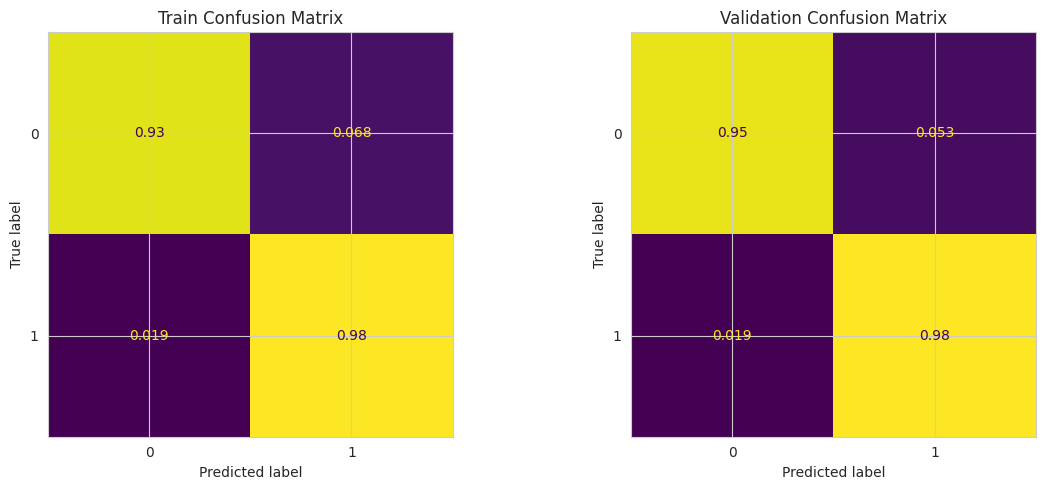

–ó–≤—ñ—Ç –∫–ª–∞—Å–∏—Ñ—ñ–∫–∞—Ü—ñ—ó –Ω–∞ –≤–∞–ª—ñ–¥–∞—Ü—ñ–π–Ω—ñ–π –≤–∏–±—ñ—Ä—Ü—ñ:
              precision    recall  f1-score   support

           0     0.9452    0.9474    0.9463      1255
           1     0.9815    0.9806    0.9810      3562

    accuracy                         0.9720      4817
   macro avg     0.9633    0.9640    0.9637      4817
weighted avg     0.9720    0.9720    0.9720      4817



In [ ]:
def objective(params):
    clf = lgb.LGBMClassifier(
        n_estimators=int(params['n_estimators']),  # –ö—ñ–ª—å–∫—ñ—Å—Ç—å –¥–µ—Ä–µ–≤ —É –∞–Ω—Å–∞–º–±–ª—ñ (–∫—ñ–ª—å–∫—ñ—Å—Ç—å —ñ—Ç–µ—Ä–∞—Ü—ñ–π –±—É—Å—Ç–∏–Ω–≥—É)
        learning_rate=params['learning_rate'],  # –ö–æ–µ—Ñ—ñ—Ü—ñ—î–Ω—Ç, –Ω–∞ —è–∫–∏–π –∑–º–µ–Ω—à—É—î—Ç—å—Å—è –≤–Ω–µ—Å–æ–∫ –∫–æ–∂–Ω–æ–≥–æ –¥–æ–¥–∞–Ω–æ–≥–æ –¥–µ—Ä–µ–≤–∞
        max_depth=int(params['max_depth']),  # –ú–∞–∫—Å–∏–º–∞–ª—å–Ω–∞ –≥–ª–∏–±–∏–Ω–∞ –∫–æ–∂–Ω–æ–≥–æ –¥–µ—Ä–µ–≤–∞
        num_leaves=int(params['num_leaves']),  # –ú–∞–∫—Å–∏–º–∞–ª—å–Ω–∞ –∫—ñ–ª—å–∫—ñ—Å—Ç—å –ª–∏—Å—Ç–∫—ñ–≤, —â–æ –¥–æ–∑–≤–æ–ª—è—î–º–æ –∫–æ–∂–Ω–æ–º—É –¥–µ—Ä–µ–≤—É –º–∞—Ç–∏.
        min_child_weight=params['min_child_weight'],  # –ú—ñ–Ω—ñ–º–∞–ª—å–Ω–∞ —Å—É–º–∞ –≤–∞–≥ –≤—Å—ñ—Ö –≤–∏–±—ñ—Ä–æ–∫, –Ω–µ–æ–±—Ö—ñ–¥–Ω–∞ –≤ –∫—ñ–Ω—Ü–µ–≤–æ–º—É –≤—É–∑–ª—ñ
        subsample=params['subsample'],  # –ß–∞—Å—Ç–∫–∞ –≤–∏–±—ñ—Ä–æ–∫, —â–æ –≤–∏–∫–æ—Ä–∏—Å—Ç–æ–≤—É—é—Ç—å—Å—è –¥–ª—è –ø–æ–±—É–¥–æ–≤–∏ –∫–æ–∂–Ω–æ–≥–æ –¥–µ—Ä–µ–≤–∞
        colsample_bytree=params['colsample_bytree'],  # –ß–∞—Å—Ç–∫–∞ –æ–∑–Ω–∞–∫, —â–æ –≤–∏–∫–æ—Ä–∏—Å—Ç–æ–≤—É—é—Ç—å—Å—è –ø—Ä–∏ –ø–æ–±—É–¥–æ–≤—ñ –∫–æ–∂–Ω–æ–≥–æ –¥–µ—Ä–µ–≤–∞
        reg_alpha=params['reg_alpha'],  # –ü–∞—Ä–∞–º–µ—Ç—Ä —Ä–µ–≥—É–ª—è—Ä–∏–∑–∞—Ü—ñ—ó L1 (Lasso)
        reg_lambda=params['reg_lambda'],  # –ü–∞—Ä–∞–º–µ—Ç—Ä —Ä–µ–≥—É–ª—è—Ä–∏–∑–∞—Ü—ñ—ó L2 (Ridge)
        min_split_gain=params['min_split_gain'],  # –ú—ñ–Ω—ñ–º–∞–ª—å–Ω–µ –∑–º–µ–Ω—à–µ–Ω–Ω—è –≤—Ç—Ä–∞—Ç, –Ω–µ–æ–±—Ö—ñ–¥–Ω–µ –¥–ª—è –≤–∏–∫–æ–Ω–∞–Ω–Ω—è –ø–æ–¥—ñ–ª—É
        cat_feature=cat_feature_indexes  # –Ü–Ω–¥–µ–∫—Å–∏ –∫–∞—Ç–µ–≥–æ—Ä—ñ–π–Ω–∏—Ö –æ–∑–Ω–∞–∫
    )

    clf.fit(X_train, train_targets, eval_set=[(X_val, val_targets)])
    pred_proba = clf.predict_proba(X_val)[:, 1]
    AUROC = roc_auc_score(val_targets, pred_proba)

    return {'loss': -AUROC, 'status': STATUS_OK}

# –ü—Ä–æ—Å—Ç—ñ—Ä –≥—ñ–ø–µ—Ä–ø–∞—Ä–∞–º–µ—Ç—Ä—ñ–≤
space = {
    'n_estimators': hp.quniform('n_estimators', 50, 500, 25),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'max_depth': hp.quniform('max_depth', 3, 15, 1),
    'num_leaves': hp.quniform('num_leaves', 20, 150, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1),
    'min_split_gain': hp.uniform('min_split_gain', 0, 0.1)  # –¥–æ–¥–∞–Ω–æ –º—ñ–Ω—ñ–º–∞–ª—å–Ω–µ –∑–º–µ–Ω—à–µ–Ω–Ω—è –≤—Ç—Ä–∞—Ç –¥–ª—è –ø–æ–¥—ñ–ª—É
}

# –û–ø—Ç–∏–º—ñ–∑–∞—Ü—ñ—è
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=10, trials=trials)

# –ü–µ—Ä–µ—Ç–≤–æ—Ä–µ–Ω–Ω—è –∑–Ω–∞—á–µ–Ω—å –≥—ñ–ø–µ—Ä–ø–∞—Ä–∞–º–µ—Ç—Ä—ñ–≤ —É –∫—ñ–Ω—Ü–µ–≤—ñ —Ç–∏–ø–∏
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['num_leaves'] = int(best['num_leaves'])
best['min_child_weight'] = int(best['min_child_weight'])

print("–ù–∞–π–∫—Ä–∞—â—ñ –≥—ñ–ø–µ—Ä–ø–∞—Ä–∞–º–µ—Ç—Ä–∏: ", best)

# –ù–∞–≤—á–∞–Ω–Ω—è —Ñ—ñ–Ω–∞–ª—å–Ω–æ—ó –º–æ–¥–µ–ª—ñ –∑ –Ω–∞–π–∫—Ä–∞—â–∏–º–∏ –≥—ñ–ø–µ—Ä–ø–∞—Ä–∞–º–µ—Ç—Ä–∞–º–∏
final_lgb = lgb.LGBMClassifier(
    n_estimators=best['n_estimators'],
    learning_rate=best['learning_rate'],
    max_depth=best['max_depth'],
    num_leaves=best['num_leaves'],
    min_child_weight=best['min_child_weight'],
    subsample=best['subsample'],
    colsample_bytree=best['colsample_bytree'],
    reg_alpha=best['reg_alpha'],
    reg_lambda=best['reg_lambda'],
    min_split_gain=best['min_split_gain'],
    cat_feature=cat_feature_indexes,
    missing=np.nan
)

final_lgb.fit(X_train, train_targets, eval_set=[(X_val, val_targets)])

AUROC_report(final_lgb, X_train, X_val, train_targets, val_targets)

In [ ]:
X_test_predict = final_lgb.predict(X_test)
df_sample = pd.read_csv('/content/sample_submission.csv')
df_sample['Personality'] = pd.Series(X_test_predict).map({0: 'Introvert', 1: 'Extrovert'})
df_sample.to_csv('/content/submission_s5e7_final_lgb_31_07_25.csv', index=False)

In [ ]:
# –ó–±–µ—Ä–µ–∂–µ–Ω–Ω—è –º–æ–¥–µ–ª—ñ
import joblib

In [ ]:
# –ó–±–µ—Ä–µ–∂–µ–Ω–Ω—è –º–æ–¥–µ–ª—ñ
import joblib
bank_customer = {
    'model_xgb_clf': xgb_clf,
    'model_final_clf': final_clf,
    'model_lgb_clf': lgb_clf,
    'model_final_lgb': final_lgb
}
joblib.dump(bank_customer, 'series-s5e7-31-07-25.joblib')

['series-s5e7-31-07-25.joblib']

In [ ]:
# –ü—Ä–∏–∫–ª–∞–¥ –∂—É—Ä–Ω–∞–ª—É

# Submission ‚Ññ,Date,Model Name,Parameters / Architecture,Local Validation Score,Kaggle Public Score,Comments
# 1,2025-07-30,baseline_xgb,"XGBoost, default params",0.792,0.789,Basic model, no tuning
# 2,2025-07-30,xgb_tuned_001,"max_depth=7, eta=0.1",0.802,0.801,Tuned XGB, better val
# 3,2025-07-30,rf_ensemble,"RandomForest + XGBoost blending",0.810,0.798,Overfit on local val
# 4,2025-07-30,nn_dropout_aug,"NeuralNet with dropout, augmentation",0.805,0.805,First NN, good performance
# 5,2025-07-30,xgb_late_sub,"Final tuned XGB",0.812,,To be used as final late submission
